## Evaluation for Readability

### Readability Score Definition:
- Higher scores indicate more complex text, which is harder to read.
- Lower scores mean the text is easier to read.

### Readability Hypotheses:
- **KJV vs. BBE**:
  - KJV, with its archaic language, should have a higher readability score than BBE, indicating it's more complex. This is to confirm BBE's inherent simplicity.
- **KJV vs. MVP/Gemma**:
  - MVP and Gemma-generated texts, intended to emulate BBE's simpler style, should have lower readability scores than KJV. This reflects that these models are learning to generate easier-to-read text from KJV/BBE pairs.
- **BBE vs. MVP/Gemma**:
  - MVP and Gemma-generated texts should have similar readability scores to BBE, indicating they effectively emulate BBE's level of simplicity. This suggests no significant difference in readability between these models and BBE.

### This notebook will statistically test these hypotheses

### Import packages

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('punkt')
from scipy.stats import wilcoxon
import scipy.stats as stats

[nltk_data] Downloading package punkt to /home/jiax1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_rows', None) 

In [3]:
bible_df = pd.read_csv('final_merged_test_df.csv')

### Load in dataset with 3000 familiar words as documented in the 1995 Readability Revisited: The New Dale-Chall Readability Formula

The New Dale-Chall Readability Formula provides a robust measure of text complexity by focusing on familiar words rather than traditional metrics like syllable count or word length. This approach is particularly suited for analyzing readability in texts where vocabulary plays a significant role, such as the Bible. The formula uses a list of 3,000 words commonly understood by fourth-grade students, emphasizing familiar vocabulary. This emphasis allows the formula to gauge readability based on the simplicity or complexity of the text, making it ideal for comparing archaic texts like the King James Version (KJV) with modern versions like the Bible in Basic English (BBE). Given the formula's reliance on familiar words, it is well-suited for analyzing shorter texts or passages.

In [4]:
url = "https://gist.githubusercontent.com/Abhishek-P/e00edcc6f508640fe24f263f5836a7dc/raw/166225e09fb8b554deff37ec344ad5ca40dab2fb/dale-chall-3000-words.txt"

familiar_words_df = pd.read_csv(url, sep=" ", header=None)
familiar_words_df = familiar_words_df.T  
familiar_words_df.columns = ["word"]  
familiar_words_df['word'] = familiar_words_df['word'].str.lstrip('\t') # Strip leading tab characters from the 'word' column

### Refer to https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula for the implementation/formula for Dale-Chall Readability Score

In [5]:
def dale_chall_readability(text, familiar_words_df):
    # Tokenize the text into words
    words = re.findall(r'\b\w+\b', text.lower())
    
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)
    
    total_words = len(words)
    total_sentences = len(sentences)

    # Check which words are difficult (not in the familiar words list)
    familiar_words = set(familiar_words_df['word'])
    difficult_words = [word for word in words if word not in familiar_words]
    
    difficult_words_perc = (len(difficult_words) / total_words) * 100
    
    words_per_sentence = total_words / total_sentences
    
    # Calculate the Dale–Chall readability score
    raw_score = 0.1579 * difficult_words_perc + 0.0496 * words_per_sentence
    
    # Adjust the score if difficult words percentage is above 5%
    if difficult_words_perc > 5:
        readability_score = raw_score + 3.6365
    else:
        readability_score = raw_score
        
    return readability_score, difficult_words_perc, words_per_sentence

### Calculate the readability score for each bible text

In [6]:
bible_with_readability_df = bible_df.copy() 

# KJV Readability
bible_with_readability_df[['KJV_readability_score', 'KJV_difficult_words_percentage', 'KJV_words_per_sentence']] = \
    bible_with_readability_df['KJV'].apply(lambda text: pd.Series(dale_chall_readability(text, familiar_words_df)))

# BBE Readability
bible_with_readability_df[['BBE_readability_score', 'BBE_difficult_words_percentage', 'BBE_words_per_sentence']] = \
    bible_with_readability_df['BBE'].apply(lambda text: pd.Series(dale_chall_readability(text, familiar_words_df)))

# Gemma BBE Readability
bible_with_readability_df[['gemma_bbe_readability_score', 'gemma_bbe_difficult_words_percentage', 'gemma_bbe_words_per_sentence']] = \
    bible_with_readability_df['gemma_bbe'].apply(lambda text: pd.Series(dale_chall_readability(text, familiar_words_df)))

# MVP BBE Readability
bible_with_readability_df[['mvp_bbe_readability_score', 'mvp_bbe_difficult_words_percentage', 'mvp_bbe_words_per_sentence']] = \
    bible_with_readability_df['mvp_bbe'].apply(lambda text: pd.Series(dale_chall_readability(text, familiar_words_df)))

In [8]:
columns_to_describe = ['KJV_readability_score', 'BBE_readability_score', 'gemma_bbe_readability_score', 'mvp_bbe_readability_score']
bible_with_readability_df[columns_to_describe].describe()

,KJV_readability_score,BBE_readability_score,gemma_bbe_readability_score,mvp_bbe_readability_score
count,78.000000,78.000000,78.000000,78.000000
mean,9.235441,8.016270,8.074006,7.910239
std,1.673951,1.325268,1.476984,1.649406
min,0.620000,1.859690,0.620000,0.694400
25%,8.377108,7.308442,7.216907,7.315899
50%,9.352400,8.028700,8.040717,7.962019
75%,10.118229,8.835475,8.927771,8.667822
max,13.336199,10.862955,12.349947,13.040390


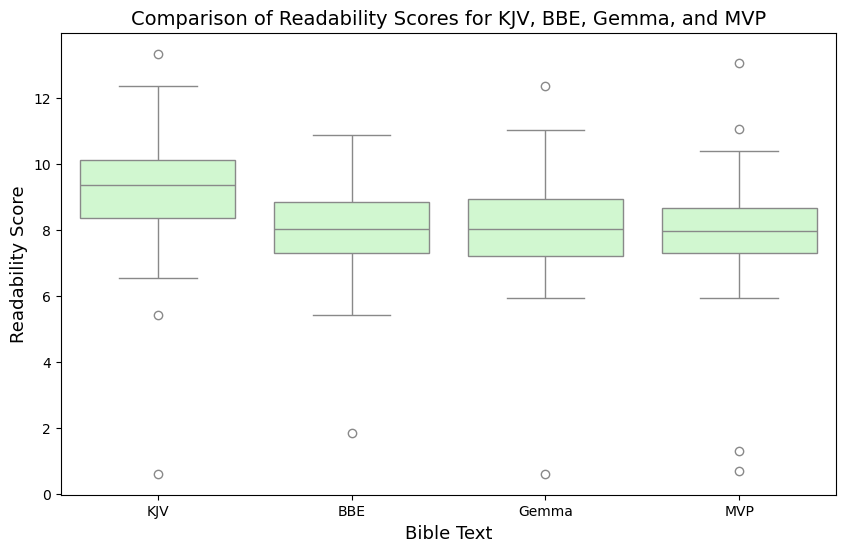

In [23]:
readability_df = bible_with_readability_df[[
    'KJV_readability_score', 'BBE_readability_score', 'gemma_bbe_readability_score', 'mvp_bbe_readability_score'
]].copy()  

readability_df.rename(
    columns={
        'KJV_readability_score': 'KJV',
        'BBE_readability_score': 'BBE',
        'gemma_bbe_readability_score': 'Gemma',
        'mvp_bbe_readability_score': 'MVP'
    },
    inplace=True
)

boxplot_readability_data = pd.melt(
    readability_df,
    var_name='Bible Text',  
    value_name='Readability Score'
)

boxplot_color = "#CBFEC9"  

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Bible Text',  
    y='Readability Score', 
    data=boxplot_readability_data,
    hue='Bible Text',  
    palette=[boxplot_color] * 4, 
    legend=False  
)
plt.title("Comparison of Readability Scores for KJV, BBE, Gemma, and MVP", fontsize=14)
plt.xlabel("Bible Text", fontsize=13)  
plt.ylabel("Readability Score", fontsize=13)

plt.show()

### Visually, from the box plot above, it appears that BBE, Gemma, and MVP are very similar to each other in terms of readability whereas KJV is harder to read generally. 

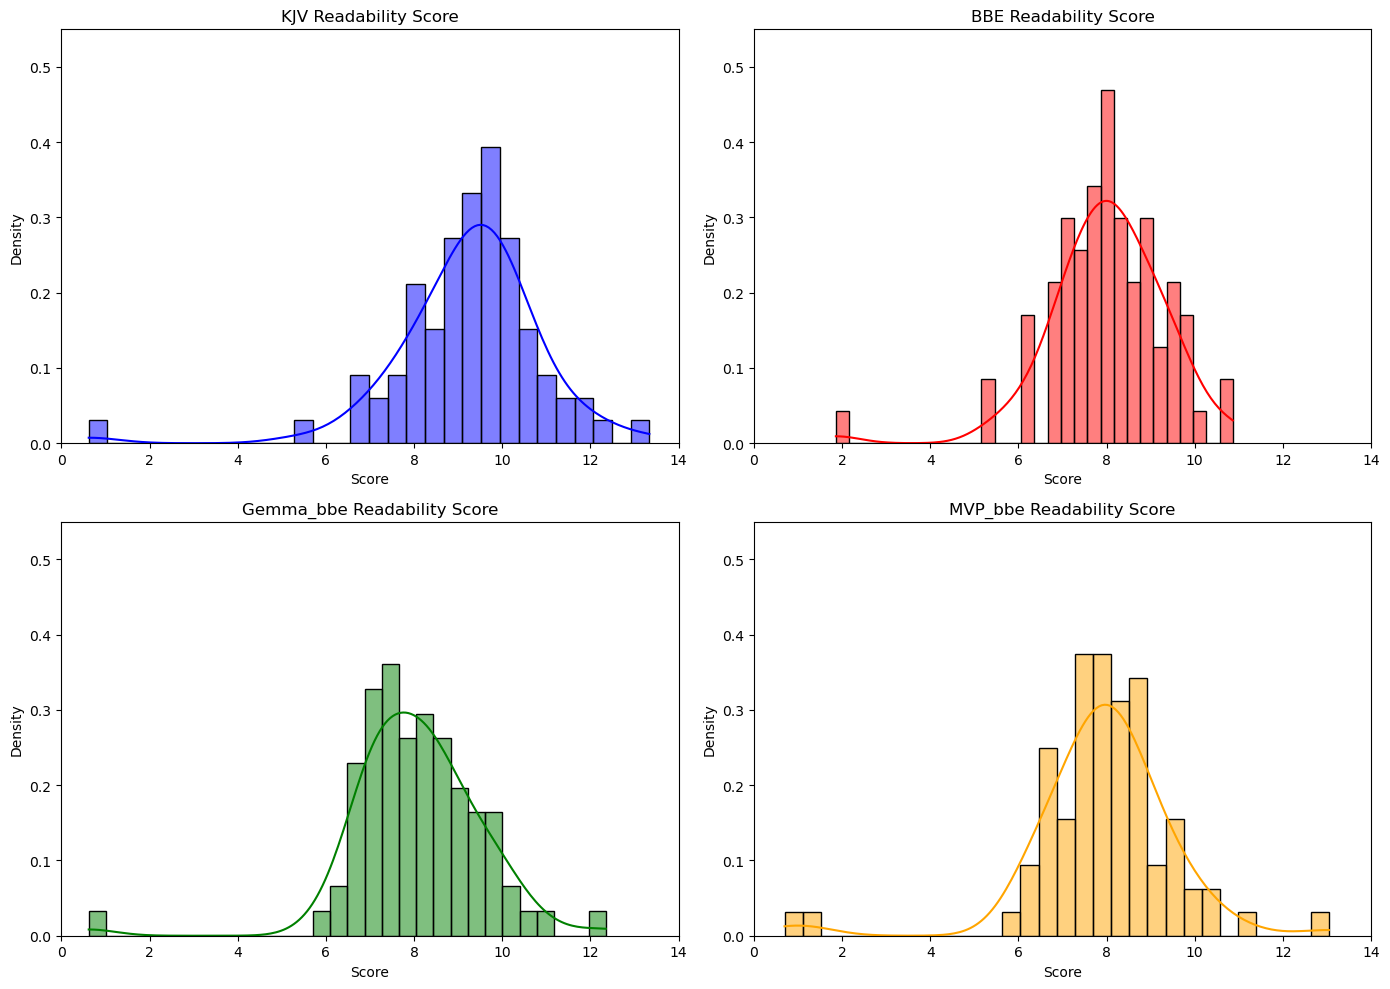

In [9]:
plt.figure(figsize=(14, 10)) 

# Plotting KJV_readability_score
plt.subplot(2, 2, 1)  # Top-left subplot
sns.histplot(
    bible_with_readability_df['KJV_readability_score'], bins=30, kde=True, color='blue', stat='density'
)
plt.title('KJV Readability Score')
plt.xlabel('Score')
plt.ylabel('Density')
plt.xlim(0, 14)  # Fixed x-axis range
plt.ylim(0, 0.55)  # Fixed y-axis range

# Plotting BBE_readability_score
plt.subplot(2, 2, 2)  # Top-right subplot
sns.histplot(
    bible_with_readability_df['BBE_readability_score'], bins=30, kde=True, color='red', stat='density'
)
plt.title('BBE Readability Score')
plt.xlabel('Score')
plt.ylabel('Density')
plt.xlim(0, 14)  # Fixed x-axis range
plt.ylim(0, 0.55)  # Fixed y-axis range

# Plotting gemma_bbe_readability_score
plt.subplot(2, 2, 3)  # Bottom-left subplot
sns.histplot(
    bible_with_readability_df['gemma_bbe_readability_score'], bins=30, kde=True, color='green', stat='density'
)
plt.title('Gemma_bbe Readability Score')
plt.xlabel('Score')
plt.ylabel('Density')
plt.xlim(0, 14)  # Fixed x-axis range
plt.ylim(0, 0.55)  # Fixed y-axis range

# Plotting mvp_bbe_readability_score
plt.subplot(2, 2, 4)  # Bottom-right subplot
sns.histplot(
    bible_with_readability_df['mvp_bbe_readability_score'], bins=30, kde=True, color='orange', stat='density'
)
plt.title('MVP_bbe Readability Score')
plt.xlabel('Score')
plt.ylabel('Density')
plt.xlim(0, 14)  # Fixed x-axis range
plt.ylim(0, 0.55)  # Fixed y-axis range

# Adjust subplot layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

### Similarly, the KDE/histogram plots show that KJV seem to be harder to read generally compared to the other 3. But now let's statistically test this!

### First let's check normality to determine whether to use a parametric or non parametric test

In [25]:
def check_normality(data):
    return stats.shapiro(data)  

shapiro_kjv = check_normality(bible_with_readability_df['KJV_readability_score'])
shapiro_bbe = check_normality(bible_with_readability_df['BBE_readability_score'])
shapiro_gemma = check_normality(bible_with_readability_df['gemma_bbe_readability_score'])
shapiro_mvp = check_normality(bible_with_readability_df['mvp_bbe_readability_score'])

print("Shapiro-Wilk Test for KJV Readability Score:", shapiro_kjv)
print("Shapiro-Wilk Test for BBE Readability Score:", shapiro_bbe)
print("Shapiro-Wilk Test for Gemma Readability Score:", shapiro_gemma)
print("Shapiro-Wilk Test for MVP Readability Score:", shapiro_mvp)

Shapiro-Wilk Test for KJV Readability Score: ShapiroResult(statistic=0.8822194933891296, pvalue=2.9865407213947037e-06)
Shapiro-Wilk Test for BBE Readability Score: ShapiroResult(statistic=0.9291915893554688, pvalue=0.0003200873325113207)
Shapiro-Wilk Test for Gemma Readability Score: ShapiroResult(statistic=0.8885443210601807, pvalue=5.2509622037177905e-06)
Shapiro-Wilk Test for MVP Readability Score: ShapiroResult(statistic=0.8505499362945557, pvalue=2.227817788025277e-07)


#### None of them are normally distributed

### Use Wilcoxon Signed-Rank Test, a non-parametric test

In [27]:
# Wilcoxon Signed-Rank Test to compare KJV with BBE readability scores
wilcoxon_kjv_bbe = stats.wilcoxon(
    bible_with_readability_df['KJV_readability_score'],
    bible_with_readability_df['BBE_readability_score'],
    alternative='greater'
)

# Wilcoxon Signed-Rank Test to compare KJV with MVP readability scores
wilcoxon_kjv_mvp = stats.wilcoxon(
    bible_with_readability_df['KJV_readability_score'],
    bible_with_readability_df['mvp_bbe_readability_score'],
    alternative='greater'
)

# Wilcoxon Signed-Rank Test to compare KJV with Gemma readability scores
wilcoxon_kjv_gemma = stats.wilcoxon(
    bible_with_readability_df['KJV_readability_score'],
    bible_with_readability_df['gemma_bbe_readability_score'],
    alternative='greater'
)

# Wilcoxon Signed-Rank Test to compare BBE with MVP readability scores (two-tailed)
wilcoxon_bbe_mvp = stats.wilcoxon(
    bible_with_readability_df['BBE_readability_score'],
    bible_with_readability_df['mvp_bbe_readability_score'],
    alternative='two-sided'
)

# Wilcoxon Signed-Rank Test to compare BBE with Gemma readability scores (two-tailed)
wilcoxon_bbe_gemma = stats.wilcoxon(
    bible_with_readability_df['BBE_readability_score'],
    bible_with_readability_df['gemma_bbe_readability_score'],
    alternative='two-sided' 
)

# Display the test results
print("Wilcoxon Test for KJV vs. BBE Readability Score:", wilcoxon_kjv_bbe)
print("Wilcoxon Test for KJV vs. MVP Readability Score:", wilcoxon_kjv_mvp)
print("Wilcoxon Test for KJV vs. Gemma Readability Score:", wilcoxon_kjv_gemma)
print("Wilcoxon Test for BBE vs. MVP Readability Score (two-tailed):", wilcoxon_bbe_mvp)
print("Wilcoxon Test for BBE vs. Gemma Readability Score (two-tailed):", wilcoxon_bbe_gemma)

Wilcoxon Test for KJV vs. BBE Readability Score: WilcoxonResult(statistic=2880.0, pvalue=1.2641322658633399e-11)
Wilcoxon Test for KJV vs. MVP Readability Score: WilcoxonResult(statistic=3042.0, pvalue=3.7559368501615514e-14)
Wilcoxon Test for KJV vs. Gemma Readability Score: WilcoxonResult(statistic=2680.0, pvalue=1.665480342276583e-12)
Wilcoxon Test for BBE vs. MVP Readability Score (two-tailed): WilcoxonResult(statistic=1326.0, pvalue=0.28535302310829125)
Wilcoxon Test for BBE vs. Gemma Readability Score (two-tailed): WilcoxonResult(statistic=1386.0, pvalue=0.441580975466875)


- **Higher Readability Score for KJV than BBE:**
The Wilcoxon test for KJV vs. BBE readability scores shows a test statistic of 2880.0 and a p-value of 1.27e-11, indicating a significant difference. This supports the hypothesis that KJV, with its archaic language, has a higher readability score (more complex and harder to read) than BBE, confirming that BBE's simplified structure is easier to read.

- **Higher Readability Score for KJV than MVP/Gemma:**
The Wilcoxon tests for KJV vs. MVP and KJV vs. Gemma readability scores have test statistics of 3042.0 and 2680.0 with p-values of 3.76e-14 and 1.67e-12, respectively. These significant results support the hypothesis that the generated text by MVP and Gemma is less complex than KJV, aligning with the expected simplification in BBE style.

- **Similar Readability Score between BBE and MVP/Gemma:**
The Wilcoxon tests for BBE vs. MVP and BBE vs. Gemma readability scores have test statistics of 1326.0 and 1386.0 with p-values of 0.29 and 0.44. These non-significant p-values suggest that there is no statistically significant difference in readability scores between BBE and MVP, and BBE and Gemma. This supports the hypothesis that MVP and Gemma generate text with readability levels similar to BBE, suggesting they effectively emulate BBE's simpler readability level.